In [1]:
!pip install -r ../requirements.txt

In [2]:
# Uncomment the lines below to download the data from the Zenodo repositories and 
# unzip it in the data folder

#%cd ../data

#!wget https://zenodo.org/record/7576814/files/source.zip?download=1 -O source.zip
#!unzip source.zip
#!rm source.zip
#!mv source/WEIGHTS .
#!rm -r source

# !wget https://zenodo.org/records/15027080/files/data.zip?download=1 -O data.zip
# !unzip data.zip
# !rm data.zip

#%cd ../src

In [3]:
from dataset import SolarPanelDataset
from pathlib import Path
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision.transforms import v2

In [4]:

data_path = Path("../data")

xlsx_path = data_path / "solar_panel_data_madagascar.xlsx"
img_path = data_path / "img"
seg_weights_path = data_path / "WEIGHTS" / "model_bdappv_seg.pth"

dataset = SolarPanelDataset(img_path, xlsx_path, "seg", "pan")

In [5]:
img, mask = dataset[0]
resize = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Resize((299, 299))
    ])
normalize = v2.Normalize(mean = (0.485, 0.456, 0.406), std = (0.229, 0.224, 0.225))
norm_img, norm_mask = normalize(resize(img)), resize(mask)

In [6]:
model = torch.load(seg_weights_path, weights_only=False)
model.eval()

DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

In [7]:
threshold = 0.5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)
predicted = model.forward(norm_img.unsqueeze(0).to(device))

prediction = predicted['out']
prediction = (prediction - torch.min(prediction)) / (torch.max(prediction) - torch.min(prediction) + 0.000000001)
binary_output = (prediction >= threshold).long().squeeze(1).detach().cpu().numpy()[0]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000002].


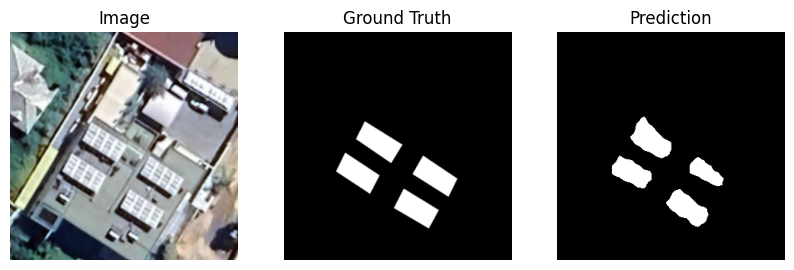

In [8]:
img_np = resize(img).permute(1, 2, 0).numpy()
mask_np = resize(mask).squeeze().numpy()
binary_output_np = binary_output.squeeze()

fig, axes = plt.subplots(1, 3, figsize=(10, 5))

axes[0].imshow(img_np)
axes[0].axis("off")
axes[0].set_title("Image")

axes[1].imshow(mask_np, cmap="gray")
axes[1].axis("off")
axes[1].set_title("Ground Truth")

axes[2].imshow(binary_output_np, cmap="gray")
axes[2].axis("off")
axes[2].set_title("Prediction")

plt.show()